# Solving a Dynamic Programming Problem

In [1]:
import numpy as np
# import scipy 
from scipy.optimize import brentq    #equation solver
from scipy import optimize
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as chebyshev
import numba
from scipy import interpolate

## Value Function Iteration

In [2]:
alpha  = 0.33
beta   = 0.98
delta  = 0.13
A      = 2

@numba.njit
def f(k):
    return A*k**alpha + (1-delta)*k
@numba.njit
def fk(k):
    return A*alpha*k**(alpha-1) + (1-delta)

@numba.njit
def util(c):
    return np.log(c)


In [3]:
kstar = ((1/beta - 1 + delta)/A/alpha)**(1/(alpha-1))
kstar

9.091084887868014

In [4]:
assert np.isclose(beta*fk(kstar), 1)

In [5]:
# grid
k = np.linspace(0.01, 15, 1500)

In [6]:
# Compute value function today, from guess Value function tomorrow
@numba.njit
def Vendog(kplus, k, Vplus):
        value = util(max(f(k) - kplus, 1E-10)) + beta * Vplus # avoid negative consumption
        return  value

# Backward iteration
@numba.njit
def backward_iterate(maxindex, V, k):
    
    maxindex = np.empty_like(k)
    # loop over the grid k
    for ik, k_cur in enumerate(k):

        value = np.empty_like(k)
        
        for ik2, k_cur2 in enumerate(k):
            
            #compute value function for all availabe saving choices
            value[ik2] = Vendog(k[ik2], k_cur, V[ik2])
        
        # find optimal saving decision
        index         = np.argmax(value)
        maxindex[ik]  = index
        # compute new value function
        V[ik]     = value[index]

    return maxindex, V

In [7]:
# Iteration algorithm
@numba.njit
def ss_policy(k):
    
    maxindex = np.zeros_like(k)
    V    = np.zeros_like(k)
    Vold    = np.zeros_like(k)
    
    for it in range(2000):
        
        maxindex, V = backward_iterate(maxindex, V, k)   
        
        if it % 10 == 1 and  np.linalg.norm(V - Vold) < 1E-5:

            print("convergence in", it, " iterations!")
            return maxindex.astype(np.int32), V
        

        Vold = np.copy(V) # avoid updating both Vold and V by making a copy
        
        

In [28]:
%time maxindex, V = ss_policy(k)

convergence in 251  iterations!
CPU times: user 5.68 s, sys: 16 ms, total: 5.7 s
Wall time: 5.69 s


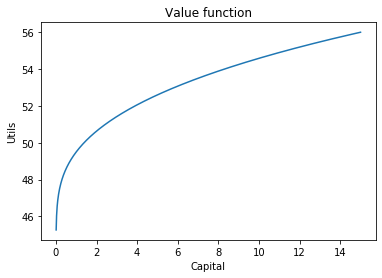

In [29]:
plt.plot(k, V)
plt.xlabel("Capital")
plt.ylabel('Utils')
plt.title('Value function');

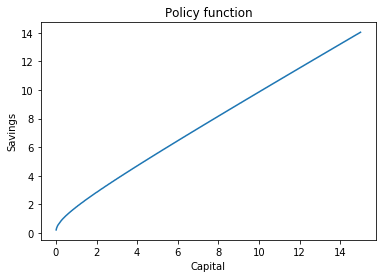

In [30]:
plt.plot(k, k[maxindex.astype(int)])
plt.xlabel("Capital")
plt.ylabel("Savings")
plt.title('Policy function');

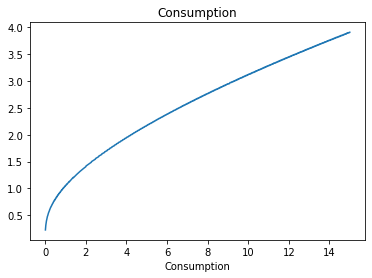

In [31]:
c = f(k) - k[maxindex.astype(int)]
plt.plot(k, c)
plt.xlabel("Capital")
plt.xlabel("Consumption")
plt.title('Consumption');

In [32]:
## Steady state level of capital
kstar = k[k[maxindex] == k]
kstar

array([9.09])

In [8]:
@numba.njit
def policy_interp(x, k, maxindex):
    policy = np.interp(x, k, k[maxindex])
    return policy

@numba.njit
def timeseries(start, periods, k, maxindex):
    series = np.empty(periods)
    series[0] = start
    for t in range(periods-1):
        series[t+1]  = policy_interp(series[t], k, maxindex)
    return series


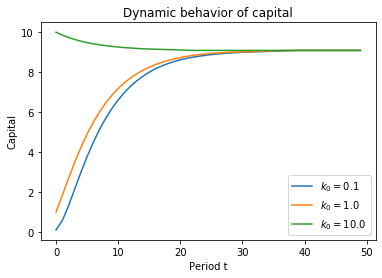

In [34]:
start = np.array([0.1, 1, 10])
T = 50

for element in start:
    series = timeseries(element, T, k, maxindex)
    plt.plot(range(T), 
    series, label=r'$k_0 = {j} $'.format(j=element))
plt.legend()
plt.xlabel('Period t')
plt.ylabel('Capital')
plt.title('Dynamic behavior of capital');

This model predicts rapid convergence of capital towards the steady state over the medium run. It would predict rapid convergence of wealth across countries.

### Howard policy improvement

In [8]:
# compute utility conditional on policy function
@numba.njit
def U_pol(maxindex, k):
    U = np.empty_like(k)
    
    for ik, k_cur in enumerate(k):
        U[ik] = util(max(f(k_cur) - k[maxindex[ik]], 1E-5))
    return U


# Howard Value iteration for given policy
@numba.njit
def Howard(maxindex, k, V_guess, UC):
    
    V_update = np.empty_like(V_guess)
    
    for ik, k_cur in enumerate(k):
        
        V_update[ik] = UC[ik] + beta * V_guess[ik]

    return V_update



In [9]:
# Iteration algorithm
@numba.njit
def ss_policy_howard(k, howard=1):
    
    maxindex = np.zeros_like(k)
    V    = np.zeros_like(k)
    Vold    = np.zeros_like(k)
    
    for it in range(20000):
#         print(it)
        maxindex, V = backward_iterate(maxindex, V, k)   
        print(np.linalg.norm(V - Vold))
        if it % 10 == 1 and  np.linalg.norm(V - Vold) < 1E-5:

            print("convergence in", it, " iterations!")
            return maxindex.astype(np.int32), V
        
        Vold = np.copy(V) # avoid updating both Vold and V by making a copy
        
        if it > 10:
            ind = maxindex.astype(np.int32)
            UC = U_pol(ind, k)        # Compute utility conditional on grid and policy function

            for it2 in range(1000):
#                 print("Number of iterations", it2)
                V = Howard(ind, k, Vold, UC)   
#                 print(np.linalg.norm(V - V_old))
                if it % 10 == 1 and  np.linalg.norm(V - Vold) < 1E-5:
#                     print("convergence in", it2, " iterations!")
                    V = np.copy(V)
                    Vold = np.copy(V)
                    break
                    
                elif it2 == 1000:
                
                        print('Howard Improvement did not converge!');
                    
                Vold = np.copy(V)

In [ ]:
%time maxindex_howard, V_howard = ss_policy_howard(k)

The algorithm is not converging with Howard improvement

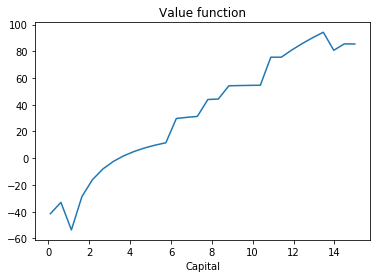

In [118]:
plt.plot(k, V_howard)
plt.xlabel("Capital")
plt.title('Value function');

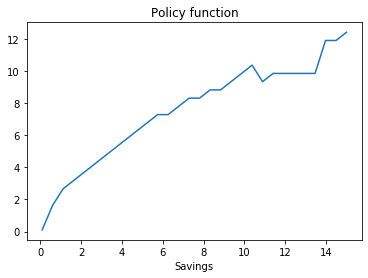

In [119]:
plt.plot(k, k[maxindex_howard.astype(int)])
plt.xlabel("Capital")
plt.xlabel("Savings")
plt.title('Policy function');

## Policy Function Iteration - Method I

### Euler equation

First-order and envelope conditions

$$
\begin{align}
u'(c(k)) &= \beta [V_k(k_+)] \\
V_k(k) &= f_k(k) u'(c(k)) \\
\end{align}
$$

can be combined to obtain a Euler equation

$$
u'(c(k)) = \beta \mathbb{E}[f_k(k_+(k))u'(c(k_+(k)))]
$$

In [39]:
@numba.njit
def up(c):
    return 1/c

In [40]:
# @numba.jit
def Euler_err_cubic(kplus, tck, k):
    err = up(max(f(k) - kplus, 1E-5)) - beta * fk(kplus) * up(interpolate.splev(kplus, tck))
    return err

# @numba.jit
def backward_iterate_cubic(cplus, k):

    kplus = np.empty(len(k))
    cendog = np.empty(len(k))
    tck = interpolate.splrep(k, cplus)
#     fun = lambda x: Euler_err_cubic(x, tck, k)
    
    for ik, k_cur in enumerate(k):
        
        res = optimize.root(Euler_err_cubic, cplus[ik], args=(tck, k_cur), method='hybr')
        kplus[ik] = res.x                   # Value of the root
        cendog[ik] = f(k_cur) - kplus[ik]   # Budget constraint
    
    return cendog


In [41]:

def ss_policy_cubic(k):
    c = np.empty(len(k))
    cplus = 0.2*k
    for it in range(1000):

        c = backward_iterate_cubic(cplus, k) 
#         print(np.linalg.norm(cplus - c))
        if it % 10 == 1 and  np.linalg.norm(cplus - c) < 1E-10:
#             print(f'convergence in {it} iterations!')
            return interpolate.splrep(k, c)
        cplus = np.copy(c)
    

In [42]:
%time tck = ss_policy_cubic(k)

CPU times: user 48.7 s, sys: 171 ms, total: 48.9 s
Wall time: 48.1 s


No handles with labels found to put in legend.


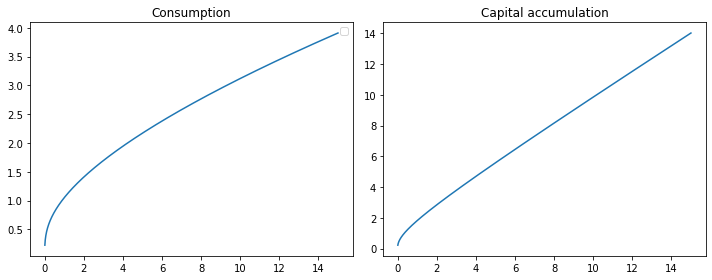

In [43]:
c = interpolate.splev(k, tck)
savings = f(k) - c
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Consumption')
ax2.set_title('Capital accumulation')
ax1.plot(k, c)
ax2.plot(k, savings)
ax1.legend()
plt.tight_layout()

In [48]:
#Find a fixed point
fun = lambda x: f(x) - interpolate.splev(x, tck)
kstar = optimize.fixed_point(fun, [7, 10])[0]
kstar

9.091084887881347

### Policy Function Iteration - Method II

In [49]:
def BC(kplus, kpplus):
    #Get consumption from budget constraint
    cons = f(kplus) - kpplus
    if cons < 0:
        return 10E-10
    else:
        return cons

def Euler(cplus, kplus):
    # Get consumption from Euler
    euler = cplus / (beta * fk(kplus))
    return euler

def backward_iterate_II(kplus, k, kbar):
    # init
    kpplus = np.empty(len(k))
    cendog = np.empty(len(k))
    kendog = np.empty(len(k))
    cplus = np.empty(len(k))
    
    # Use policy function to get K''
    tck = interpolate.splrep(k, kplus)
    kpplus = interpolate.splev(kplus, tck)
#     print(kpplus)

    # Use BC tomorrow, Euler today and BC today to get back policy func
    for ik, k_cur in enumerate(k):
        
        cplus[ik]  = BC(kplus[ik], kpplus[ik])    #Budget constraint tomorrow
        cendog[ik] = Euler(cplus[ik], kplus[ik])  # Euler equation today
        kendog[ik] = min(max(f(k[ik]) - cendog[ik], 0), kbar) # Budget constraint today lower bar = 0, upper bar to define
        
    return kendog


In [50]:
def ss_policy_II(k, kbar):
    
    knew = np.empty(len(k))
    kplus = 0.5*k
    
    for it in range(1000):
#         print("Iteration number:", it)
        knew = backward_iterate_II(kplus, k, kbar) 
        
        if it % 10 == 1 and  np.linalg.norm(knew - kplus) < 1E-10:
            print(f'convergence in {it} iterations!')
            tck_out = interpolate.splrep(k, knew)
            return tck_out
        
        kplus = np.copy(knew)
    

In [52]:
%time tck = ss_policy_II(k, 5*kstar)

convergence in 111 iterations!
CPU times: user 560 ms, sys: 2 µs, total: 560 ms
Wall time: 558 ms


No handles with labels found to put in legend.


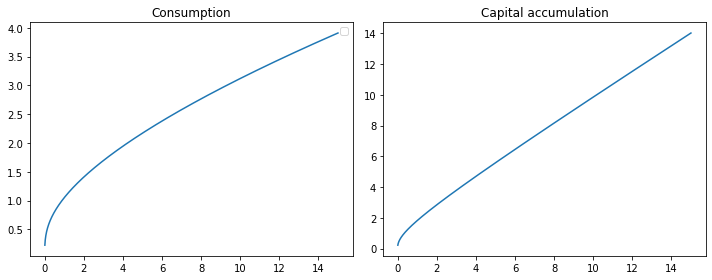

In [53]:
savings = interpolate.splev(k, tck)
c = f(k) - savings
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Consumption')
ax2.set_title('Capital accumulation')
ax1.plot(k, c)
ax2.plot(k, savings)
ax1.legend()
plt.tight_layout()

In [66]:
#Find a fixed point
fun = lambda x: interpolate.splev(x, tck)
kstar = optimize.fixed_point(fun, [7, 10])[0]
kstar

9.091084887841202

### Endogenous Grid Points Method

In [55]:
def up_inv(c):
    return 1/c
def up(c):
    return 1/c

In [56]:
def get_cendog(cplus, fk, up, up_inv, beta, k):
    return up_inv(beta * (fk(k) *up(cplus)))

def backward_iterate_endog(cplus, k):                 # Should interpret k as k tomorrow here
    c_endog = up_inv(beta * (fk(k) *up(cplus)))       # if save k tomorrow, what would be the optimal c today
    c = np.empty_like(c_endog)
    tck = interpolate.splrep(c_endog + k, c_endog)    # cendog + k is production today
    c = interpolate.splev(f(k), tck)
    return c

In [57]:
def ss_policy_endog(k):
    c = 0.3*k
    for it in range(2000):
        c = backward_iterate_endog(c, k)
        if it % 10 == 1 and  np.max(np.abs(c - cold)) < 1E-10:
            print(f'convergence in {it} iterations!')
            return c
        cold = c

In [59]:
%time c = ss_policy_endog(k)

convergence in 111 iterations!
CPU times: user 63.1 ms, sys: 0 ns, total: 63.1 ms
Wall time: 61.5 ms


No handles with labels found to put in legend.


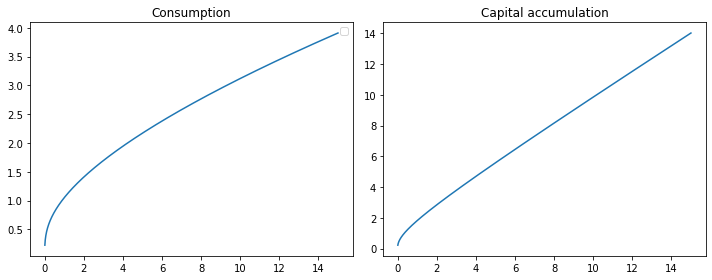

In [60]:

savings = f(k) - c
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Consumption')
ax2.set_title('Capital accumulation')
ax1.plot(k, c)
ax2.plot(k, savings)
ax1.legend()
plt.tight_layout()

In [67]:
#Find a fixed point
tck = interpolate.splrep(k, c)
fun = lambda x: f(x) - interpolate.splev(x, tck)
kstar = optimize.fixed_point(fun, [7, 10])[0]
kstar

9.091084888650906

### Comparing methods

In [69]:
solving_time1 = %timeit -n1 -r 1 -o ss_policy(k)
solving_time2 = %timeit -n1 -r 1 -o ss_policy_cubic(k)
solving_time3 = %timeit -n1 -r 1 -o ss_policy_II(k, kstar)
solving_time4 = %timeit -n1 -r 1 -o ss_policy_endog(k)
print(solving_time1)

convergence in 251  iterations!
5.87 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
54.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
convergence in 111 iterations!
43.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.87 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Using optimize.root for policy function iteration is very costly.

# Problem 2

## a) Stating the problem


$$
\max_{\left\{c_t, a_{t+1}\right\}_{t=0}^\infty} \mathop{E_0}  \left[\sum_{t=0}^{\infty} \beta^t u(c_t)\right]
$$
subject to: 

$$
c_t+a_{t+1}\leq Ra_t+y_t,\ \forall t
$$



The First Order Condition yields the usual Euler equation, which in this case, corresponds to:

$$
exp(-\sigma c_t)=R\beta \mathop{E_t}\{exp(-\sigma c_{t+1})\}
$$



## b) Computing allocation: Planner's problem

When 
$ 
\epsilon=0 
$

we are back to the deterministic case, and we can take the expectation operators from our equations. 

The euler equation then becomes:

$
exp(-\sigma c_t)=R\beta \{exp(-\sigma c_{t+1})\}
$

Now we can substitute in our guess for $c_{t+1}=B(Ra_{t+1}+y_{t})+D$:


$$
exp(-\sigma c_t)= R\beta \{exp(-\sigma (B(Ra_{t+1}+y_{t+1})+D))\}\\
                = R\beta \{exp(-\sigma B(Ra_{t+1}+\bar{y})-\sigma D)\}
$$

applying $\ln()$ at both sides:
$$-\sigma c_t =\ln(R\beta) -\sigma B(Ra_{t+1}+\bar{y})-\sigma D$$
and now replacing $a_{t+1}$ from the budget constraint:
$$-\sigma c_t =\ln(R\beta) -\sigma B(R(a_t+y_t-c_t)+\bar{y})-\sigma D$$
So we can leave $c_t$ on one side yielding:
$$c_t =\frac{BR}{1+BR}(Ra_t+y_t)+\frac{\sigma D -\ln(\beta R)+\sigma B \bar{y}}{\sigma (1+BR)}$$
Now, using the method of undetermined coefficients and our guess we get:
$$B=\frac{R-1}{R}$$
and
$$D=-\frac{\ln(\beta R)}{\sigma (R-1)}+\frac{\bar{y}}{R}$$



## c) Introducing exogenous market incompleteness

When $\epsilon\neq0$ we go back to the original case in which:
$$
exp(-\sigma c_t)=R\beta \mathop{E_t}\{exp(-\sigma c_{t+1})\}
$$
Again, by substituting our guess we get:
$$
exp(-\sigma c_t)= R\beta \mathop{E_t}\{exp(-\sigma (B(Ra_{t+1}+y_{t+1})+D))\}\\
$$
And manipulating this equation we get:
$$
1= R\beta exp(\sigma c_t) exp(-\sigma BR a_{t+1}-\sigma D)\mathop{E_t}\{exp(-\sigma y_{t+1})\}\\
$$
Now, we can use the additional fact that $\epsilon_t$ is an i.i.d. random variable and leverage the fact that this assumption implies that:
$$ exp(\sigma c_t) exp(-\sigma BR a_{t+1}) = exp(\sigma(c_t-BRa_{t+1}))$$

is also independent of $t$ since $\mathop{E_t}\{exp(-\sigma y_{t+1})\}$ is constant in time. Now using these two facts we get:

\begin{align*}
c_t-BR a_{t+1} &= c_t - BR(Ra_t+y_t-c_t)\\ &=c_t (1+BR)-BR(Ra_t+y_t)=c_t(1+BR)-R(c_t-D)\\ &=c_t(1+BR-R)+RD
\end{align*}

And now, from the fact that the path of consumption is constant as we've discussed before we know that: $1+BR-R=0$ so that we get the same expression for $B$ as in the deterministic case. Using this and plugging it back in the previous equations yields:

$$
1=R\beta exp(\sigma(R-1)D)\mathop{E_t}[exp(-\sigma By_{t+1})]
$$

so that:

$$
D=-\tfrac{\ln(R\beta)\mathop{E_t}[exp(-\sigma B y_{t+1})]}{\sigma (R-1)}
$$

Now, to compare this value of D with the previous one, notice that using Jensen's Inequality:

$$
\mathop{E_t}[exp(-\sigma B y_{t+1})]>exp(-\sigma B \mathop{E_t}[y_{t+1}])=exp(-\sigma B \bar{y})
$$

Meaning that by going from $\epsilon=0$ to $\epsilon\neq0$ the value of $D$ is lower. The intuition is given by the fact that this utility function exhibits $\textit{prudence}$ so there is a precautionary motive for savings. Recall that $D$ represents the constant level of consumption that all individuals wish to maintain, since it does not vary with (a,y). So that if uncertainty is higher, this value is going to be lower to increase precautionary savings.



# Problem 3

## a) Arrow - Debreu Equilibrium
For this setting, we need to keep track of the state space. In the given setting, we only have two possible states: $s\in\{H,L\}$.
Where 
$s=L$ means that the individual is on the low endowment trajectory, and analogously for the $s=H$ case. Let $c_t(s)$ be the consumption that individual with state $s$ gets at time $t$. Let $p_t$ be the price of the consumption good at time $t$. Note that since the aggregate endowment at every period is 1 (i.e. no aggregate uncertainty) the price does not depend on the state.

Individuals solve:


$$
\max_{\left\{c_t(s)\right\}_{t=0}^\infty} \mathop{E_{-1}}  \left[\sum_{t=0}^{\infty} \beta^t u(c_t(s))\right]
$$
subject to: 
 
$$\sum_{t=0}^{\infty} \sum_s p_t c_t(s)\leq \sum_{t=0}^{\infty} \sum_s p_t y_t(s)$$


In this context, an Arrow-Debreu equilibrium is defined as a sequence of consumptions $\{c_t(s)\}_{t=0, s\in\{L,H\}}^{\infty}$ and a sequence of prices $\{p_t\}_{t=0}^{\infty}$ such that they solve the individuals problem and market clears: $c_t(H)+c_t(L)=1$, for every $t$.



## b) Computing allocations: Planner's problem
Since there is no aggregate uncertainty and there is not any other friction by solving the planners problem for two equally weighted agents we would get a constant level of consumption across time/states. Now let's solve more formally:

$$
\max_{\left\{c_t(s)\right\}_{t=0}^\infty} \mathop{E_{-1}}  \left[\sum_{t=0}^{\infty} \beta^t u(c_t(s))\right]
$$
 subject to: $\sum_{t=0}^{\infty} p_t c_t(H)+\sum_{t=0}^{\infty} p_t c_t(L)\leq \sum_{t=0}^{\infty} p_t[0.75-(0.25)^{t+1}]+ \sum_{t=0}^{\infty} p_t[0.25+(0.25)^{t+1}]$.\\
 
 The First Order Conditions for $t$ and $t=0$ yield:
 
 $$
[c_t(s)]: \ \ \beta^t\frac{1}{2c_t(s)}- \lambda p_t=0 
$$
$$
[c_0(s)]: \ \ \frac{1}{2c_0(s)}- \lambda=0
 $$

Together,  and with $c_t(s)=c_0$ they imply that $p_t=\beta^t$. From the Budget Constraint we get that:
$$
\sum_{t=0}^{\infty} \beta^t \bar{c}+\sum_{t=0}^{\infty} \beta^t \bar{c}= \sum_{t=0}^{\infty} \beta^t
$$
so that $\bar{c}=\frac{1}{2}$.



## c) Sequential incomplete market
Now we need to be carefull with the timing of the problem. At $t=-1$ agents don't know their type, and since assets can't depend on the realization of the state of the world, there is no trade. Only once the uncertainty of types has been resolved there can be trade. In this case, individual of type $s$ solve the following problem:


$$
\max_{\left\{c_t(s),a(s)_{t+1}\right\}_{t=0}^\infty}  \sum_{t=0}^{\infty} \beta^t \ln(c_t(s))
$$
 subject to:
 
$$c_t(s)+a_{t+1}(s)\leq (1+r_t)a_t(s)+y_t(s)$$ $$a_{t+1}(s)\geq -b_{t+1} \quad \text{for all t}$$


In this context, a sequence of markets equilibrium is defined as a sequence of consumptions $\{c(H)_t,c(L)_t\}_{t=0}^{\infty}$, assets $\{a(H)_{t+1},a(L)_{t+1}\}_{t=0}^{\infty}$, and prices $\{r_t\}_{t=0}^{\infty}$ such that they solve individuals' problems and markets clear: $c_t(H)+c_t(L)=1$ and $a_{t+1}(H)+a_{t+1}(L)=0$, for every $t$.



## d)  Computing allocation under incomplete market
We know that the FOC for the individual's problem in this case yields the regular Euler equation:

$$
u'(c(s)_t)=\beta u'(c(s)_{t+1})(1+r_{t+1}) \Leftrightarrow c(s)_{t+1}=\beta (1+r_{t+1})c(s)_{t}
$$
Now if we sum up both euler equations and impose market clearing in the goods market we get that: $1=\beta (1+r_{t+1})$, for all $t$. Also from this condition and going back to the individual's euler equations we get that: $c(s)_t=c(s)_{t+1}$. With this, we can go back to the individual's intertemporal budget constraint and compute $\bar{c}_H$ and $\bar{c}_L$:

$$
\sum_{t=0}^{\infty} \frac{\bar{c}_H}{(1+r)^t} = \sum_{t=0}^{\infty} \frac{[0.75-(0.25)^{t+1}]}{(1+r)^t}
$$

$$
\sum_{t=0}^{\infty} \frac{\bar{c}_L}{(1+r)^t} = \sum_{t=0}^{\infty} \frac{[0.25+(0.25)^{t+1}]}{(1+r)^t}
$$

After some manipulations we get:

\begin{align*}
\frac{\bar{c}_H}{r}&=\frac{0.75}{r}-0.25\frac{1}{1-\frac{0.25}{1+r}}\\&=\frac{\frac{1}{2}+\beta\frac{1}{16}}{1-0.25\beta}
\end{align*}

and $\bar{c}_L=1-\bar{c}_H$ from the goods' market clearing condition.

We can tell that $\bar{c}_H\in(0.5,0.75)$ and is increasing in $\beta$ as we would expect. Since the $s=H$ has an increasing income trajectory, to consume a constant amount he'll have to borrow at the beginning, whereas the situation is the exact opposite for the $s=L$ type.

Of course the borrowing constraint holds with slack for both agents since the way it is constructed (natural debt limit) imposes zero consumption forever and that's clearly not optimal with the given utility functions. Also note that here we do not get that consumption is across types as we've discussed previously. The reason is that in this context it is not possible to self-insure against states, and agents can only smooth consumption throughout time.


## e) No borrowing constraint
Now we impose the restriction of $a_t(s) \geq0$, for all $s$ and $t$. Under this scenario, we know that the agents of type H will reach the constrain, as they would like to borrow:

$$
c_t(H) = y_t(H)
$$

On the other hand, the agents of type $ L $ are not constrained because they did not want to borrow assets under the looser constraint. The Euler equation still holds for them.

$$
u'(c_t(L)) = \beta (1+r) u'(c_{t+1}(L))
$$

By market clearing we know that agents of type $L$ wont save. The budget constraint implies that they'll have to consume their endowments every period, so that $c_t(s)=y_t(s)$ for both types. This means that:

$$
\beta (1+r) =  \frac{u'(c_t(L))}{u'(c_{t+1}(L))} = \frac{y_{t+1}(L)}{y_t(L)} = \frac{0.25+(0.25)^{t+2}}{0.25+(0.25)^{t+1}}=\frac{5}{8} < 1
$$

Agents of type $L$ would like to save but by market clearing we know that supply and demand of assets is zero because of the no-borrowing constraint. What is happening is that price of capital is increasing to the point when agents of type $L$ are indifferent betweent holding assets or not. 